In [1]:
using CSV, DataFrames
using FileIO, Dates
using PyCall
using DelimitedFiles
using CairoMakie

include("./src/cubes.jl")
include("./src/motifs_analysis.jl")

@pyimport powerlaw as powlaw

## Triangles

In [115]:
region = "japan"
motif = "Triangle"
if region == "romania"
    cell_sizes = [3.0];
    minimum_magnitudes = [2];
elseif region == "california"
    cell_sizes = [1.0, 2.0];
    minimum_magnitudes = [2];
elseif region == "italy"
    cell_sizes = [4.5, 5.0,];
    minimum_magnitudes = [2];
elseif region == "japan"
    cell_sizes = [2.5, 3.0];
    minimum_magnitudes = [3, 2];
end

2-element Vector{Int64}:
 3
 2

In [116]:
weighted_by = "totalenergy"
cell_size = cell_sizes[2]
minimum_magnitude = minimum_magnitudes[2]

2

In [117]:
 # Read data
 path = "./data/"
 filepath = path * region * ".csv"
 df = CSV.read(filepath, DataFrame);

 if weighted_by == "totalenergy"
     weight_key = 1
 else 
     weight_key = 2
 end

 # Make path for plot results
 mkpath("./motifs_selected_plots/$weighted_by/$region")
 
 # Read results of fit to get xmin 
 results = CSV.read("./motifs/$weighted_by/$region/results$motif.csv", DataFrame);
 xmin_results = results[(results.weighted_by .== weighted_by) .& 
        (results.region .== region) .& 
        (results.motif .== motif) .& 
        (results.cell_size .== cell_size) .&
        (results.minmag .== minimum_magnitude),:].xmin;

In [118]:
#############################################################################################################################################################
# Filter by magnitude
df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
# Split into cubes
df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size, energyRelease=true);

# Get the motif
network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
motifs = readdlm(network_target_path * motif_filename, ',', Int64);

# Energy and areas calculator
motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
areas = area_triangles(motifs, df_filtered_cubes);

# Area weighted by total/mean energy
area_weight = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small areas (triangles on the vertical for example)
    if areas[key] > 1
        push!(area_weight, areas[key]/motif_energy[key][weight_key])
    end
end
#############################################################################################################################################################
# THE FIT
# Select xmin based on weighted_by, region, motif, cell_size and minmag

# Powerlaw fit
fit = powlaw.Fit(area_weight, xmin=xmin_results);
alpha = fit.alpha
xmin = fit.xmin
KS = fit.power_law.KS(data=area_weight)

#############################################################################################################################################################
#############################################################################################################################################################
# THE PLOTS 
# CCDF of truncated data (fitted), x and y values
x_ccdf, y_ccdf = fit.ccdf()

# The fit (from theoretical power_law)
fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

# Round up the data
alpha = round(alpha, digits=2)
xmin = round(xmin, digits=4)
KS = round(KS, digits=3)


0.018

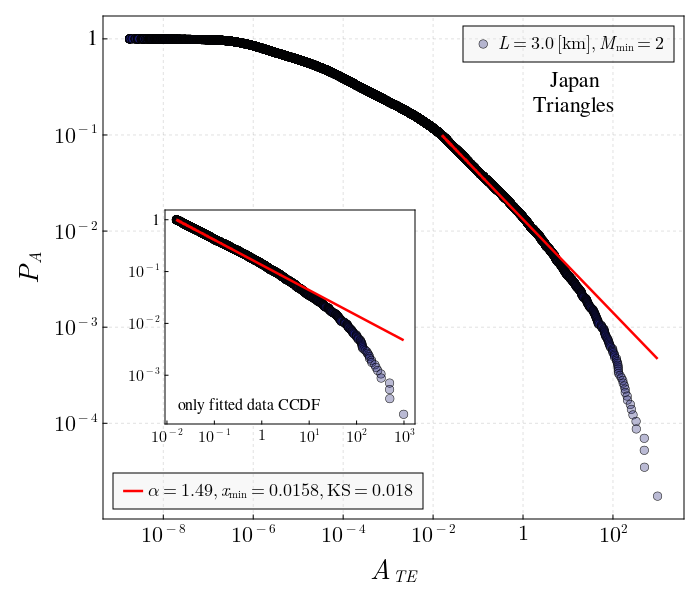

In [119]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"A_{TE}", ylabel = L"P_A", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)

x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(area_weight)


sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
    color=(:midnightblue, 0.3), strokewidth=0.5, marker=:circle, markersize=12)

# Fit through truncated data
# Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
ln1 = lines!(ax1, x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw,
    color=:red, linewidth=2.5) 

axislegend(ax1, [sc1], [L"L=%$(cell_size)\,\mathrm{[km]},\,M_\mathrm{min}=%$(minimum_magnitude)"], position = :rt, bgcolor = (:grey90, 0.25), labelsize=18);
axislegend(ax1, [ln1], [L"\alpha=%$(alpha),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)"], position = :lb, bgcolor = (:grey90, 0.25), labelsize=18);

ax1.xticks = ([10^(-8), 10^(-6), 10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-8}", L"10^{-6}", L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
ax1.yticks = ([10^(-5), 10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

if region == "romania"
    text!(ax1, "Romania", space = :relative, position = Point2f(0.75, 0.85), fontsize=22)
    text!(ax1, "Triangles", space = :relative, position = Point2f(0.736, 0.8), fontsize=22)
elseif region == "california"
    text!(ax1, "California", space = :relative, position = Point2f(0.75, 0.85), fontsize=22)
    text!(ax1, "Triangles", space = :relative, position = Point2f(0.736, 0.8), fontsize=22)
elseif region == "italy"
    text!(ax1, "Italy", space = :relative, position = Point2f(0.77, 0.85), fontsize=22)
    text!(ax1, "Triangles", space = :relative, position = Point2f(0.736, 0.8), fontsize=22)
elseif region == "japan"
    text!(ax1, "Japan", space = :relative, position = Point2f(0.77, 0.85), fontsize=22)
    text!(ax1, "Triangles", space = :relative, position = Point2f(0.74, 0.8), fontsize=22)
end

########################################### TRUNCATED
# CCDF of truncated data (fitted), the plot, (re-normed)
ax2 = Axis(fig, bbox = BBox(165,415,176,390), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

sc2 = scatter!(ax2, x_ccdf, y_ccdf,
    color=(:midnightblue, 0.3), strokewidth=0.5, marker=:circle, markersize=12)

# Fit through truncated data (re-normed)
ln2 = lines!(ax2, x_powlaw, y_powlaw,
        color=:red, linewidth=2.5) 

text!(ax2, "only fitted data CCDF", space = :relative, position = Point2f(0.05, 0.05))

translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)

ax2.xticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2), 10^(3)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1", L"10^{1}", L"10^{2}", L"10^{3}"])
ax2.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0)],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])



save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude))_area_$(weighted_by)_all_data.png", fig, px_per_unit=5)
save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude))_area_$(weighted_by)_all_data.pdf", fig)
fig 

## Tetrahedrons

In [128]:
region = "japan"
motif = "Tetrahedron"

if region == "romania"
    cell_sizes = [5.0];
    minimum_magnitudes = [3];
elseif region == "california"
    cell_sizes = [1.0, 2.0];
    minimum_magnitudes = [2];
elseif region == "italy"
    cell_sizes = [4.0, 5.0];
    minimum_magnitudes = [2];
elseif region == "japan"
    cell_sizes = [2.5, 3.0];
    minimum_magnitudes = [3];
end;

In [129]:
weighted_by = "totalenergy"
cell_size = cell_sizes[2]
minimum_magnitude = minimum_magnitudes[1]

3

In [130]:
 # Read data
 path = "./data/"
 filepath = path * region * ".csv"
 df = CSV.read(filepath, DataFrame);

 if weighted_by == "totalenergy"
     weight_key = 1
 else 
     weight_key = 2
 end

 # Make path for plot results
 mkpath("./motifs_selected_plots/$weighted_by/$region")
 
 # Read results of fit to get xmin 
 results = CSV.read("./motifs/$weighted_by/$region/results$motif.csv", DataFrame);
 xmin_results = results[(results.weighted_by .== weighted_by) .& 
        (results.region .== region) .& 
        (results.motif .== motif) .& 
        (results.cell_size .== cell_size) .&
        (results.minmag .== minimum_magnitude),:].xmin;

In [131]:
#############################################################################################################################################################
# Filter by magnitude
df_filtered = df[df.Magnitude .> minimum_magnitude,:] 
# Split into cubes
df_filtered, df_filtered_cubes = region_cube_split(df_filtered,cell_size=cell_size,energyRelease=true);

# Get the motif
network_target_path = "./networks/$(region)/cell_size_$(string(cell_size))km/"
motif_filename = "motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude)).csv"
motifs = readdlm(network_target_path * motif_filename, ',', Int64);

# Energy and volumes calculator
motif_energy = total_mean_energy(motifs, df_filtered, df_filtered_cubes);
volumes = volume_tetrahedrons(motifs, df_filtered_cubes);

# Volumes weighted by total/mean energy
volume_weight = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small volumes (triangles on the vertical for example)
    if volumes[key] > 1
        push!(volume_weight, volumes[key]/motif_energy[key][weight_key])
    end
end
#############################################################################################################################################################
# THE FIT
# Powerlaw fit
fit = powlaw.Fit(volume_weight, xmin=xmin_results);
alpha = fit.alpha
xmin = fit.xmin
KS = fit.power_law.KS(data=volume_weight)

#############################################################################################################################################################
#############################################################################################################################################################
# THE PLOTS 
# CCDF of truncated data (fitted), x and y values
x_ccdf, y_ccdf = fit.ccdf()

# The fit (from theoretical power_law)
fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

# Round up the data
alpha = round(alpha, digits=2)
xmin = round(xmin, digits=4)
KS = round(KS, digits=3)

0.032

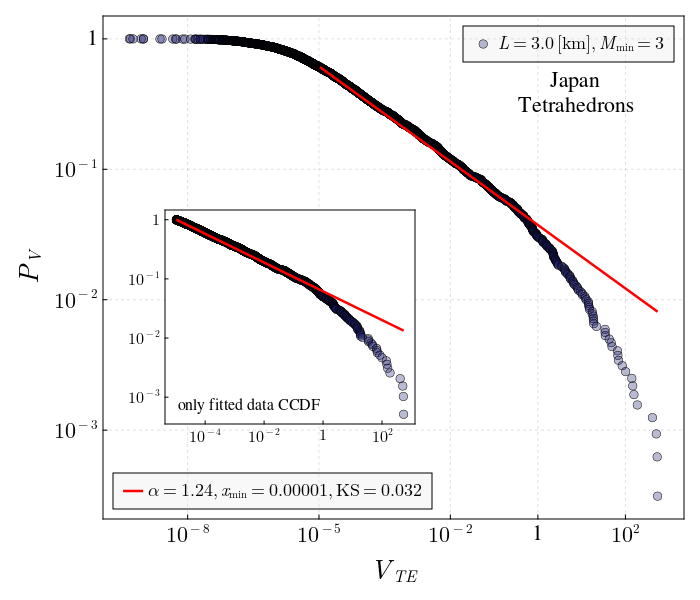

In [132]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))

########################################### ALL
# CCDF of all data scattered 
fig = Figure(resolution = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1,1], xlabel = L"V_{TE}", ylabel = L"P_V", xscale=log10, yscale=log10, ylabelsize = 28,
    xlabelsize = 28, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10, xticklabelsize=22, yticklabelsize=22)

x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(volume_weight)


sc1 = scatter!(ax1, x_ccdf_original_data, y_ccdf_original_data,
    color=(:midnightblue, 0.3), strokewidth=0.5, marker=:circle, markersize=12)

# Fit through truncated data
# Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
ln1 = lines!(ax1, x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw,
    color=:red, linewidth=2.5) 

axislegend(ax1, [sc1], [L"L=%$(cell_size)\,\mathrm{[km]},\,M_\mathrm{min}=%$(minimum_magnitude)"], position = :rt, bgcolor = (:grey90, 0.25), labelsize=18);
axislegend(ax1, [ln1], [L"\alpha=%$(alpha),\, x_{\mathrm{min}}=0.00001,\, \mathrm{KS}=%$(KS)"], position = :lb, bgcolor = (:grey90, 0.25), labelsize=18);

ax1.xticks = ([10^(-8),10^(-5),10^(-2),10^(0),10^(2)],[L"10^{-8}", L"10^{-5}", L"10^{-2}","1", L"10^{2}"])
# ax1.yticks = ([10^(-4), 10^(-3), 10^(-2),10^(-1),1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])
ax1.yticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 1 ],[L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", "1"])

if region == "romania"
    text!(ax1, "Romania", space = :relative, position = Point2f(0.74, 0.85), fontsize=22)
    text!(ax1, "Tetrahedrons", space = :relative, position = Point2f(0.715, 0.8), fontsize=22)
elseif region == "california"
    text!(ax1, "California", space = :relative, position = Point2f(0.735, 0.85), fontsize=22)
    text!(ax1, "Tetrahedrons", space = :relative, position = Point2f(0.715, 0.8), fontsize=22)
elseif region == "italy"
    text!(ax1, "Italy", space = :relative, position = Point2f(0.777, 0.85), fontsize=22)
    text!(ax1, "Tetrahedrons", space = :relative, position = Point2f(0.715, 0.8), fontsize=22)
elseif region == "japan"
    text!(ax1, "Japan", space = :relative, position = Point2f(0.77, 0.85), fontsize=22)
    text!(ax1, "Tetrahedrons", space = :relative, position = Point2f(0.715, 0.8), fontsize=22)
end


########################################### TRUNCATED
# CCDF of truncated data (fitted), the plot, (re-normed)
ax2 = Axis(fig, bbox = BBox(165,415,176,390), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

sc2 = scatter!(ax2, x_ccdf, y_ccdf,
    color=(:midnightblue, 0.3), strokewidth=0.5, marker=:circle, markersize=12)

# Fit through truncated data (re-normed)
ln2 = lines!(ax2, x_powlaw, y_powlaw,
        color=:red, linewidth=2.5) 

text!(ax2, "only fitted data CCDF", space = :relative, position = Point2f(0.05, 0.05))

translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)

if region == "japan"
    ax2.xticks = ([10^(-4), 10^(-2), 10^(0), 10^(2)], [L"10^{-4}", L"10^{-2}", L"1", L"10^{2}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])
else
    ax2.xticks = ([10^(-4), 10^(-3), 10^(-2), 10^(-1), 10^(0), 10^(1), 10^(2)], [L"10^{-4}", L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1", L"10^{1}", L"10^{2}"])
    ax2.yticks = ([10^(-3), 10^(-2), 10^(-1), 1 ], [L"10^{-3}", L"10^{-2}", L"10^{-1}", L"1"])
end

save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude))_area_$(weighted_by)_all_data.png", fig, px_per_unit=5)
save("./motifs_selected_plots/$weighted_by/$region/motif$(motif)_$(region)_cell_size_$(string(cell_size))km_minmag_$(string(minimum_magnitude))_area_$(weighted_by)_all_data.pdf", fig)
fig 